# Distributed representations

In this notebook we leverage the IMDB movie review dataset (which was already analyzed for the purpose of scores classification) to test various textual embeddings, going from sparse to dense representations.

In particular, we will try to see how different embeddings reflect in different semantic concepts and how much each embedding can be trusted for semantic purposes.

In order to keep things efficient, we exploit the use of sparse matrices whenever we can (we will stick to the usage of `csr_matrix` by the `scipy` package).

In [191]:
import gc
import time
from tqdm import tqdm
from functools import partial

import numpy as np
import pandas as pd
import scipy.sparse
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity as fast_cosine

import utils

%load_ext autoreload
%autoreload 2
# %matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [193]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

## Data preparation

This section is dedicated to data loading and data preparation. An important step is that the entire dataset gets preprocessed right from the start, using the `preprocess_text` function from the `utils` module.

In [104]:
dataset = utils.IMDBDataset()
dataset.preprocess()
df = dataset.dataframe
df.shape

(50000, 5)

In [105]:
df.head()

,file_id,score,sentiment,split,text
0,2257,7,1,train,sarafina fun movie songs really great sarafina...
1,4778,9,1,train,like early masterpiece elephant man lynch prov...
2,7284,8,1,train,young seen movies parents wisdom rented one wa...
3,4845,9,1,train,hello playmatesi recently watched film first t...
4,6822,7,1,train,opening night released 1977 tries ambitious pr...


In order to keep things simple and fast, we will extract a random portion of the entire dataset and do experimentation with this limited subset of reviews.

In [106]:
small_df = dataset.get_portion(amount=500, seed=RANDOM_SEED)
small_df.shape

(500, 5)

In [107]:
small_df.head()

,file_id,score,sentiment,split,text
33553,4989,7,1,test,much added much taken away great western writt...
9427,6186,10,1,train,released production code crackdown july 1934 m...
199,8806,9,1,train,chose see film day opened nationally france pe...
12447,9759,10,1,train,believe received film young buck remembered wa...
39489,445,3,0,test,upon time great american film combined horror ...


The `build_vocabulary` function takes a dataframe containing text documents in each row and extracts the set of words that appear in those documents. 

For example, if we assume to have a toy dataframe with just the two following "documents" (already pre-processed)

1. "hi my name is alessio hi how are you"
2. "hi my name is lorenzo who are you"

Then, our function will output the following vocabulary:

["alessio", "are", "hi", "how", "is", "lorenzo", "my", "name", "who", "you"]

As you can see, the vocabulary is sorted in ascending order, so that with the same documents we always get the same output.

Moreover, the function will also output two more data structures, which will be used throughout the notebook for convenience:

- Index to word dictionary: {0: "alessio", 1: "are", 2: "hi", 3: "how", 4: "is", 5: "lorenzo", 6: "my", 7: "name", 8: "who", 9: "you"}
- Word to index dictionary: {"alessio": 0, "are": 1, "hi": 2, "how": 3, "is": 4, "lorenzo": 5, "my": 6, "name": 7, "who": 8, "you": 9}

In [108]:
def build_vocabulary(df, col_name="text"):
    """
    Given a dataset, builds the corresponding word vocabulary
    """
    doc_str = " ".join(df[col_name].tolist()).replace("\n", " ").replace("\r", " ")
    words = sorted(set(doc_str.split()))
    vocabulary, inverse_vocabulary = dict(), dict()
    for i, w in tqdm(enumerate(words)):
        vocabulary[i] = w
        inverse_vocabulary[w] = i
    return vocabulary, inverse_vocabulary, words

Now, let's test the function to see if it actually works as intended$\dots$

In [109]:
toy_df = pd.DataFrame(
    {"text": ["hi my name is alessio hi how are you", "hi my name is lorenzo who are you"]}
)
toy_idx_to_word, toy_word_to_idx, toy_word_listing = build_vocabulary(toy_df)
print(f"Word listing: {toy_word_listing}")
print(f"Index to word dictionary: {toy_idx_to_word}")
print(f"Word to index dictionary: {toy_word_to_idx}")

10it [00:00, 70256.35it/s]

Word listing: ['alessio', 'are', 'hi', 'how', 'is', 'lorenzo', 'my', 'name', 'who', 'you']
Index to word dictionary: {0: 'alessio', 1: 'are', 2: 'hi', 3: 'how', 4: 'is', 5: 'lorenzo', 6: 'my', 7: 'name', 8: 'who', 9: 'you'}
Word to index dictionary: {'alessio': 0, 'are': 1, 'hi': 2, 'how': 3, 'is': 4, 'lorenzo': 5, 'my': 6, 'name': 7, 'who': 8, 'you': 9}


Since the function seems to work properly, we can build the vocabulary for our specific dataset. 

In [110]:
idx_to_word, word_to_idx, word_listing = build_vocabulary(small_df)

13413it [00:00, 747220.08it/s]


In [111]:
print(f"Number of words in the vocabulary: {len(word_listing)}")

Number of words in the vocabulary: 13413


Now we print the very first and the very last words in the vocabulary to check our preprocessing step.

In [112]:
print(list(idx_to_word.items())[:5])
print(list(word_to_idx.items())[-5:])

[(0, '#1'), (1, '#16'), (2, '#2br'), (3, '0'), (4, '000')]
[('zoundsbr', 13408), ('zuccon', 13409), ('zulu', 13410), ('zuniga', 13411), ('zuzzzuzz', 13412)]


## Similarity

In this section, we are going to define different functions to assess similarity of words. 

In particular, the most important one is about the computation of cosine similarity: about that, we give two different implementations, one that follows the definition of the measure (which is not so efficient) and one which exploits the highly-efficient implementation of the `sklearn` package (which is around $10x$ faster than my hand-made method).

In [69]:
def cosine_similarity(p, q, transpose_p=False, transpose_q=False):
    """
    Computes the cosine similarity of two d-dimensional matrices,
    where their second dimension should match
    """
    # If it is a vector, consider it as a single sample matrix
    if len(p.shape) == 1:
        p = p.reshape(1, -1)
    if len(q.shape) == 1:
        q = q.reshape(1, -1)

    # Check if dimensions match
    assert p.shape[1] == q.shape[1]

    # Check for sparsity
    if not hasattr(scipy.sparse, type(p).__name__):
        p = scipy.sparse.csr_matrix(p)
    if not hasattr(scipy.sparse, type(q).__name__):
        q = scipy.sparse.csr_matrix(q)

    # Compute cosine similarity
    p_norm = np.sqrt(p.dot(p.T).diagonal())
    q_norm = np.sqrt(q.dot(q.T).diagonal())
    norms_prod = np.outer(p_norm, q_norm)
    if transpose_p:
        res = q.dot(p.T) / norms_prod
    else:
        res = p.dot(q.T) / norms_prod
        
    return scipy.sparse.csr_matrix(res)

In [70]:
def fast_cosine_similarity(p, q, transpose_p=False, transpose_q=False, to_dense=False):
    """
    Computes the cosine similarity of two d-dimensional matrices,
    using sklearn implementation
    """
    # If it is a vector, consider it as a single sample matrix
    if len(p.shape) == 1:
        p = p.reshape(1, -1)
    if len(q.shape) == 1:
        q = q.reshape(1, -1)

    # Check for sparsity
    if not hasattr(scipy.sparse, type(p).__name__):
        p = scipy.sparse.csr_matrix(p)
    if not hasattr(scipy.sparse, type(q).__name__):
        q = scipy.sparse.csr_matrix(q)

    # Compute cosine similarity
    return (
        fast_cosine(p, q, dense_output=to_dense)
        if transpose_q
        else fast_cosine(q, p, dense_output=to_dense)
    )

The following functions are dedicated to the computation of semantic concepts, like synonyms (ideally words with high similarity) and antonyms (ideally words with low similarity).

Moreover, the `get_analogy` method tries to solve the analogy problem: for four words in the analogical relationship $a : b = c : x$ , given the first three words, $a$, $b$ and $c$, we want to find $x$. Assume the word vector for the word $w$ is $v(w)$. To solve the analogy problem, we need to find the word vector that is most similar to the result vector of $v(c)+v(b)-v(a)$. From a geometric point of view, it boils down to finding the closest point to the vertex $v(x)$ of a parallelogram, where the other vertices are given by the vector representations of $a$, $b$ and $c$.

Simple examples of analogies are the following:
- Male - female: $man : woman = son : x$ ($x$ should be $daughter$)
- Capital - country: $beijing : china = tokyo : x$ ($x$ should be $japan$)
- Adjective - superlative adjective: $bad : worst = big : x$ ($x$ should be $biggest$)
- Present tense verb - past tense verb: $do : did = go : x$ ($x$ should be $went$)

In [71]:
def word_knn(word, similarity_matrix, word_to_idx, k=1, farthest=False):
    """
    Find the k-nearest neighbors to the given word
    """
    index = word_to_idx[word]
    similarities = []
    for w, i in word_to_idx.items():
        sim = similarity_matrix[index, i]
        if sim > 0:
            similarities.append((w, sim))
    return sorted(similarities, key=lambda t: t[1], reverse=(not farthest))[1 : k + 1]


def vec_knn(vec, similarity_matrix, word_to_idx, k=1, farthest=False):
    """
    Find the k-nearest neighbors to the given vector
    """
    similarities = []
    for w, i in word_to_idx.items():
        sim = similarity_matrix[i, 0]
        if sim > 0:
            similarities.append((w, sim))
    return sorted(similarities, key=lambda t: t[1], reverse=(not farthest))[1 : k + 1]

In [174]:
def get_analogy(
    embedding_matrix, word_to_idx, token_a, token_b, token_c, token_d=None, k=1
):
    """
    Given the analogy a : b = c : x, find the word x which completes it,
    s.t. x is the most similar word to c + b - a
    """
    # Check if words are present
    if (
        not token_a in word_to_idx
        or not token_b in word_to_idx
        or not token_c in word_to_idx
    ):
        return [], None

    # Compute the x vector
    token_a_idx, token_b_idx, token_c_idx = (
        word_to_idx[token_a],
        word_to_idx[token_b],
        word_to_idx[token_c],
    )
    vecs = embedding_matrix[[token_a_idx, token_b_idx, token_c_idx]]
    x = vecs[1] - vecs[0] + vecs[2]
    if hasattr(scipy.sparse, type(x).__name__):
        x = x.toarray()
    
    # Find the analogies
    similarity_matrix = fast_cosine_similarity(x, embedding_matrix, transpose_q=True)
    analogies = vec_knn(x, similarity_matrix.transpose(), word_to_idx, k=k)
    
    # If you have the actual token, return the actual similarity
    actual_similarity = None
    if token_d is not None and token_d in word_to_idx:
        token_d_idx = word_to_idx[token_d]
        actual_similarity = similarity_matrix[0, token_d_idx]
        
    return analogies, actual_similarity

In [180]:
def test_analogies(embedding_matrix, word_to_idx, analogies, k=1):
    """
    Check if the given analogies are somehow represented in the given embedding
    
    The analogies parameter should be a dictionary as the following:
    {name: [a, b, c, x]}, where the analogy is a : b = c : x and name is
    an identifier for the analogy
    """
    # Identify analogies
    for name, analogy in analogies.items():
        found_analogy = False
        res, actual_sim = get_analogy(
            embedding_matrix,
            word_to_idx,
            analogy[0],
            analogy[1],
            analogy[2],
            token_d=analogy[3],
            k=k,
        )
        for index, value in enumerate(res):
            word, similarity = value
            if word == analogy[3]:
                found_analogy = True
                break
        print(
            f"Analogy {name}: {analogy[0]} : {analogy[1]} = {analogy[2]} : {analogy[3]}\n"
        )
        if analogy[3] not in word_to_idx:
            print(f"Word {analogy[3]} is not in the dataset\n\n")
        elif not found_analogy:
            print(f"No exact analogies found\n")
            print(f"Actual similarity: {actual_sim}\n")
            print(f"Obtained results: {[r[0] for r in res]}\n\n")
        else:
            print(f"Exact analogy found with score {res[0][1]}\n\n")

In [176]:
analogies = {
    "male-female": ["man", "woman", "son", "daughter"],
    "jj-jjs": ["bad", "worst", "big", "biggest"],
    "morph": ["free", "freely", "happy", "happily"],
    "feeling": ["poor", "money", "sad", "happiness"],
}

## Sparse embeddings

The first type of embeddings that we may want to try is in the sparse realm and can be viewed as a direct evolution of `BoW` methods, going from document by term matrices to word-word ones. 

In this notebook we are going to explore two popular embeddings:
1. The raw co-occurrence count matrix (which can be directly related to the straight document by term matrix of language models)
2. The `PPMI` matrix (which can be related to the reweighting scheme of `TF-IDF` in language models)

### Co-occurrence count matrix

The co-occurrence count matrix represents words by the context they appear in. In particular, given a vocabulary $V$ of size $|V|$ it returns a matrix $C$ of size $|V|\times |V|$ s.t. $C[i,j]=n$, where $n$ is the number of times word $j$ appears in the context of word $i$, for a specific window size. 

This representation is obviously a very sparse one, even though the higher the size window the denser the co-occurrence matrix is.

In [75]:
def dict_to_csr(term_dict):
    """
    Given a dictionary like {(i, j): v}, returns a sparse matrix m
    s.t. m[i, j] = v
    """
    keys = list(term_dict.keys())
    values = list(term_dict.values())
    shape = list(np.repeat(np.asarray(keys).max() + 1, 2))
    csr = scipy.sparse.csr_matrix((values, zip(*keys)), shape=shape)
    return csr

In [76]:
def co_occurrence_count(df, idx_to_word, word_to_idx, window_size=4):
    """
    Builds word-word co-occurrence matrix based on word counts
    """
    counts = dict()
    for doc in tqdm(df["text"]):
        doc_words = doc.split()
        for doc_word_index, central_word in enumerate(doc_words):
            central_word_index = word_to_idx[central_word]
            context = (
                doc_words[max(0, doc_word_index - window_size) : doc_word_index] + 
                doc_words[doc_word_index + 1 : min(doc_word_index + window_size + 1, len(doc_words))]
            )
            for context_word in context:   
                context_word_index = word_to_idx[context_word]
                key = (central_word_index, context_word_index)
                counts[key] = counts.get(key, 0) + 1
    sparse_matrix = dict_to_csr(counts)
    del counts
    return sparse_matrix

Let's test our vocabulary building method and, more importantly, if the co-occurrence count matrix is correct. To do so, we will use the previously defined toy dataframe containing just two "documents".

Given a window size of $1$ and the sorted vocabulary, we would like to get the following (densified) output:

|         | alessio | are | hi | how | is | lorenzo | my | name | who | you |
|:-------:|:-------:|:---:|:--:|:---:|:--:|:-------:|:--:|:----:|:---:|:---:|
| alessio |    0    |  0  |  1 |  0  |  1 |    0    |  0 |   0  |  0  |  0  |
|   are   |    0    |  0  |  0 |  1  |  0 |    0    |  0 |   0  |  1  |  2  |
|    hi   |    1    |  0  |  0 |  1  |  0 |    0    |  2 |   0  |  0  |  0  |
|   how   |    0    |  1  |  1 |  0  |  0 |    0    |  0 |   0  |  0  |  0  |
|    is   |    1    |  0  |  0 |  0  |  0 |    1    |  0 |   2  |  0  |  0  |
| lorenzo |    0    |  0  |  0 |  0  |  1 |    0    |  0 |   0  |  1  |  0  |
|    my   |    0    |  0  |  2 |  0  |  0 |    0    |  0 |   2  |  0  |  0  |
|   name  |    0    |  0  |  0 |  0  |  2 |    0    |  2 |   0  |  0  |  0  |
|   who   |    0    |  1  |  0 |  0  |  0 |    1    |  0 |   0  |  0  |  0  |
|   you   |    0    |  2  |  0 |  0  |  0 |    0    |  0 |   0  |  0  |  0  |

In [77]:
toy_co_occurrence_matrix = co_occurrence_count(
    toy_df, toy_idx_to_word, toy_word_to_idx, window_size=1
)
print("Co-occurrence count matrix:")
toy_co_occurrence_matrix.toarray()

100%|██████████| 2/2 [00:00<00:00, 5200.62it/s]

Co-occurrence count matrix:


array([[0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 2],
       [1, 0, 0, 1, 0, 0, 2, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 2, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 2, 0, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 2, 0, 2, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 0, 0, 0]])

Since the co-occurrence count matrix building function seems to work properly, we can use it over our entire dataset.

In [115]:
if "co_occurrence_matrix" in globals():
    del co_occurrence_matrix
    gc.collect()
    time.sleep(10.0)

window_size = 4
co_occurrence_matrix = co_occurrence_count(
    small_df, idx_to_word, word_to_idx, window_size
)

100%|██████████| 500/500 [00:00<00:00, 824.29it/s]


Let's see how many zero values we have in our co-occurrence matrix$\dots$

In [116]:
total_coo_dim = len(word_to_idx) ** 2
actual_coo_dim = co_occurrence_matrix.nnz
print(
    f"Dense matrix dimension: {len(word_to_idx)}x{len(word_to_idx)} = "
    + "{:.2e}".format(total_coo_dim)
)
print(f"Sparse matrix dimension: {actual_coo_dim}")
print(f"Number of zero elements: " + "{:.2e}".format(total_coo_dim - actual_coo_dim))

Dense matrix dimension: 13413x13413 = 1.80e+08
Sparse matrix dimension: 398421
Number of zero elements: 1.80e+08


In order to visualize our embeddings, we need a way to project high-dimensional spaces into 2 dimensions: this process will obviously lead to a relevant waste of information, but it's the only way to have an approximate look at how words are represented in the embedding space. 

To perform this visualization we will use two popular methods, which are `SVD` decomposition and `tSNE` (the first one being much faster than the second one).

In [125]:
words_to_highlight = ['actor', 'actress', 'movie']

In [80]:
coo_svd = utils.reduce_svd(co_occurrence_matrix, seed=RANDOM_SEED)

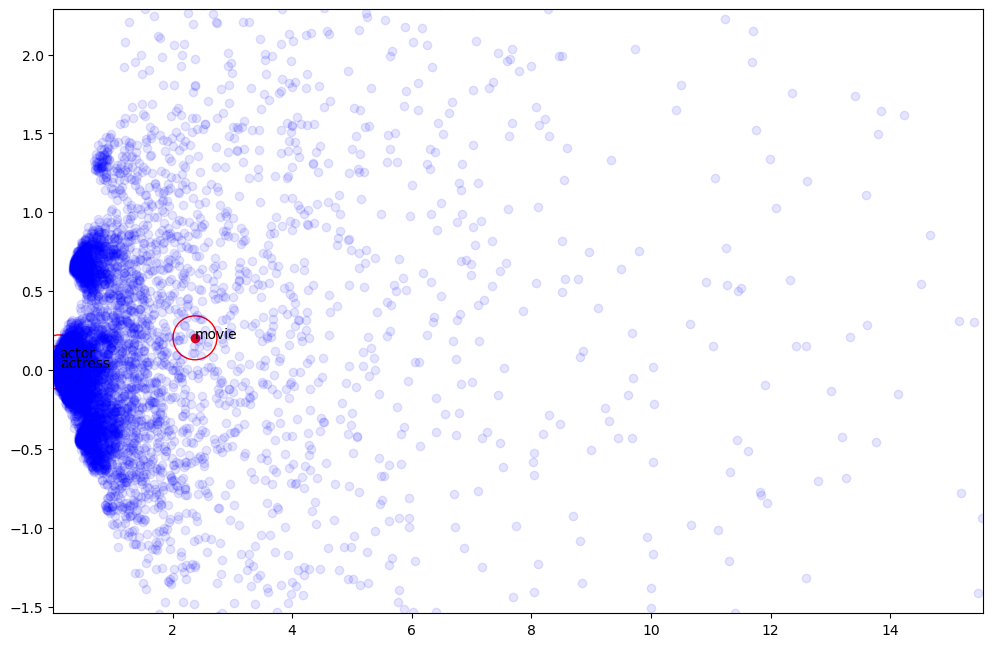

In [130]:
utils.visualize_embeddings(coo_svd, words_to_highlight, word_to_idx)

In [132]:
coo_tsne = utils.reduce_tsne(co_occurrence_matrix, seed=RANDOM_SEED)

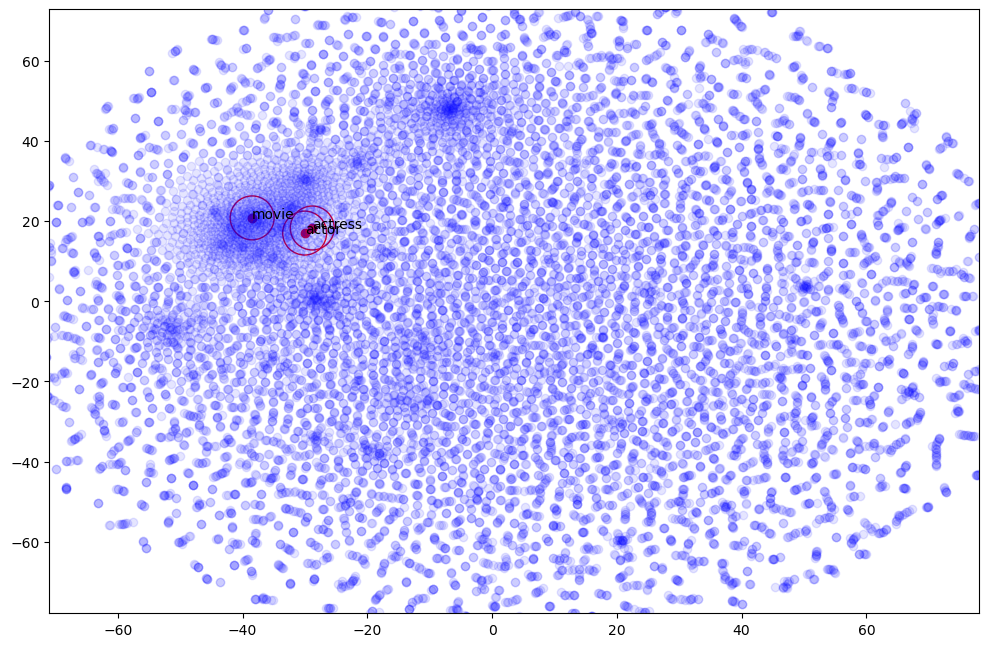

In [133]:
utils.visualize_embeddings(coo_tsne, words_to_highlight, word_to_idx)

Now we compute the cosine similarity between each pair of words, to see if some synonyms and antonyms are correctly captured by the embedding.

In [134]:
coo_similarity_matrix = fast_cosine_similarity(
    co_occurrence_matrix, co_occurrence_matrix, transpose_q=True
)

We can see that we have much less zeros w.r.t. the co-occurrence count matrix, so the sparse representation will be less effective.

In [135]:
total_coo_similarity_dim = len(word_to_idx) ** 2
actual_coo_similarity_dim = coo_similarity_matrix.nnz
print(
    f"Dense matrix dimension: {len(word_to_idx)}x{len(word_to_idx)} = "
    + "{:.2e}".format(total_coo_similarity_dim)
)
print(f"Sparse matrix dimension: {actual_coo_similarity_dim}")
print(f"Number of zero elements: " + "{:.2e}".format(total_coo_similarity_dim - actual_coo_similarity_dim))

Dense matrix dimension: 13413x13413 = 1.80e+08
Sparse matrix dimension: 44858709
Number of zero elements: 1.35e+08


Let's check some possible synonyms$\dots$

In [201]:
word_knn("film", coo_similarity_matrix, word_to_idx, k=5)

[('br', 0.8515586318289146),
 ('movie', 0.8268741754428951),
 ('good', 0.7807053288706287),
 ('one', 0.772978653599032),
 ('really', 0.7543815878567147)]

In [202]:
word_knn("good", coo_similarity_matrix, word_to_idx, k=5)

[('bad', 0.8068975857425112),
 ('br', 0.8044501617675084),
 ('movie', 0.7951025552197021),
 ('one', 0.7850195414524932),
 ('film', 0.7807053288706287)]

Let's check some possible antonyms$\dots$

In [203]:
word_knn("amazing", coo_similarity_matrix, word_to_idx, k=5, farthest=True)

[('robinson', 0.007548943712462224),
 ('swatch', 0.007642723006446788),
 ('glass', 0.008056137408713865),
 ('bafta', 0.008825056370227598),
 ('shearer', 0.009389774844349514)]

In [204]:
word_knn("worst", coo_similarity_matrix, word_to_idx, k=5, farthest=True)

[('bullitt', 0.0023940029688623785),
 ('sosuke', 0.002625911349384798),
 ('quartermain', 0.0029708795551115328),
 ('pearl', 0.003032141248870813),
 ('eve', 0.003407832566884802)]

Let's check some possible analogies$\dots$

In [177]:
test_analogies(co_occurrence_matrix, word_to_idx, analogies, k=10)

Analogy male-female: man : woman = son : daughter

No exact analogies found

Actual similarity: -0.09328034392365077

Obtained results: ['son', 'heraunt', 'traveled', 'nightgown', 'geneva', 'removes', 'tamed', 'angie', 'bridetobe', 'dickinson']


Analogy jj-jjs: bad : worst = big : biggest

No exact analogies found

Actual similarity: -0.0953543719963497

Obtained results: ['levelled', 'commercials', 'wellafter', 'prejudice', 'bullocks', 'phony', 'programmes', 'worst', 'prejudiced', 'carjumps']


Analogy morph: free : freely = happy : happily

No exact analogies found

Actual similarity: -0.0594438298277764

Obtained results: ['freely', 'gorehounds', 'towers', 'paperbr', 'clone', 'dispenses', 'eludes', 'hauntingly', 'jerking', 'cocoa']


Analogy feeling: poor : money = sad : happiness

No exact analogies found

Actual similarity: -0.016745932279117907

Obtained results: ['sad', 'requested', 'description', 'ticket', 'want', 'spent', 'buy', 'watch', 'wereby', 'declare']




As we can see, the model is not working at all at a semantic level$\dots$ We can observe that word similarity is simply based on the frequency of words s.t.
* Two highly frequent words have high similarity value
* Two infrequent words have very low similarity
* Two medium frequent words have medium similarity value

In this way, synonyms, antonyms and analogies can only be based on frequency and not on their semantic (dis)similarity, which is not what we want. So, let's see if more sophisticated methods can achieve better results$\dots$

### PPMI

`PMI` (Pointwise Mutual Information) is just a reweighting scheme of the entire co-occurrence count matrix, s.t.
$P[i,j]=\log_2{\frac{C[i,j]\cdot s_{*,*}}{s_{i,*} \cdot s_{*,j}}}$, where $s_{*,*}=\sum_{r=1}^{|V|}\sum_{c=1}^{|V|}C[r,c]$ is the sum over all the elements in the co-occurrence matrix, $s_{i,*}=\sum_{c=1}^{|V|}C[i,c]$ is the sum over row $i$ in the co-occurrence matrix and $s_{*,j}=\sum_{r=1}^{|V|}C[r,j]$ is the sum over column $j$ of the co-occurrence count matrix.

By the way, since the co-occurrence matrix is symmetric, $s_{i,*}=s_{*,i}$, so we just need to compute one of the two summations.

Instead, `PPMI` (Positive PMI) is the PMI matrix inferiorly clipped at zero (so, no negative values allowed). 

In [143]:
def convert_ppmi(co_occurrence_matrix, to_dense=False):
    """
    Converts a count-based co-occurrence matrix to a PPMI matrix
    """
    # Compute sums
    total_sum = float(co_occurrence_matrix.sum())
    row_col_sums = np.array(
        co_occurrence_matrix.sum(axis=1), dtype=np.float64
    ).flatten()

    # Get CSR matrix elements
    if not hasattr(scipy.sparse, type(co_occurrence_matrix).__name__):
        co_occurrence_matrix = scipy.sparse.csr_matrix(co_occurrence_matrix)
    data, indices, indptr = (
        list(enumerate(co_occurrence_matrix.data)),
        co_occurrence_matrix.indices,
        co_occurrence_matrix.indptr,
    )

    # Compute PPMI matrix
    ppmi_data, ppmi_indices, ppmi_indptr = [], [], [0]
    for row in tqdm(range(len(indptr) - 1)):
        for col, elem in data[indptr[row] : indptr[row + 1]]:
            pmi = np.log2(
                (elem * total_sum) / (row_col_sums[row] * row_col_sums[indices[col]])
            )
            if pmi > 0:
                ppmi_data.append(pmi)
                ppmi_indices.append(indices[col])
        if ppmi_indptr[-1] != len(ppmi_data):
            ppmi_indptr.append(len(ppmi_data))

    # Re-format as sparse matrix
    res = scipy.sparse.csr_matrix(
        (ppmi_data, ppmi_indices, ppmi_indptr), dtype=np.float64
    )
    res.eliminate_zeros()
    return res if not to_dense else res.toarray()

In [144]:
ppmi_occurrence_matrix = convert_ppmi(co_occurrence_matrix)

100%|██████████| 13413/13413 [00:05<00:00, 2239.21it/s]


We can see that the PPMI matrix is still as sparse as the raw co-occurrence count matrix.

In [145]:
total_ppmi_dim = len(word_to_idx) ** 2
actual_ppmi_dim = ppmi_occurrence_matrix.nnz
print(
    f"Dense matrix dimension: {len(word_to_idx)}x{len(word_to_idx)} = "
    + "{:.2e}".format(total_ppmi_dim)
)
print(f"Sparse matrix dimension: {actual_ppmi_dim}")
print(f"Number of zero elements: " + "{:.2e}".format(total_ppmi_dim - actual_ppmi_dim))

Dense matrix dimension: 13413x13413 = 1.80e+08
Sparse matrix dimension: 390970
Number of zero elements: 1.80e+08


As before, we proceed with visualization$\dots$

In [146]:
ppmi_svd = utils.reduce_svd(ppmi_occurrence_matrix, seed=RANDOM_SEED)

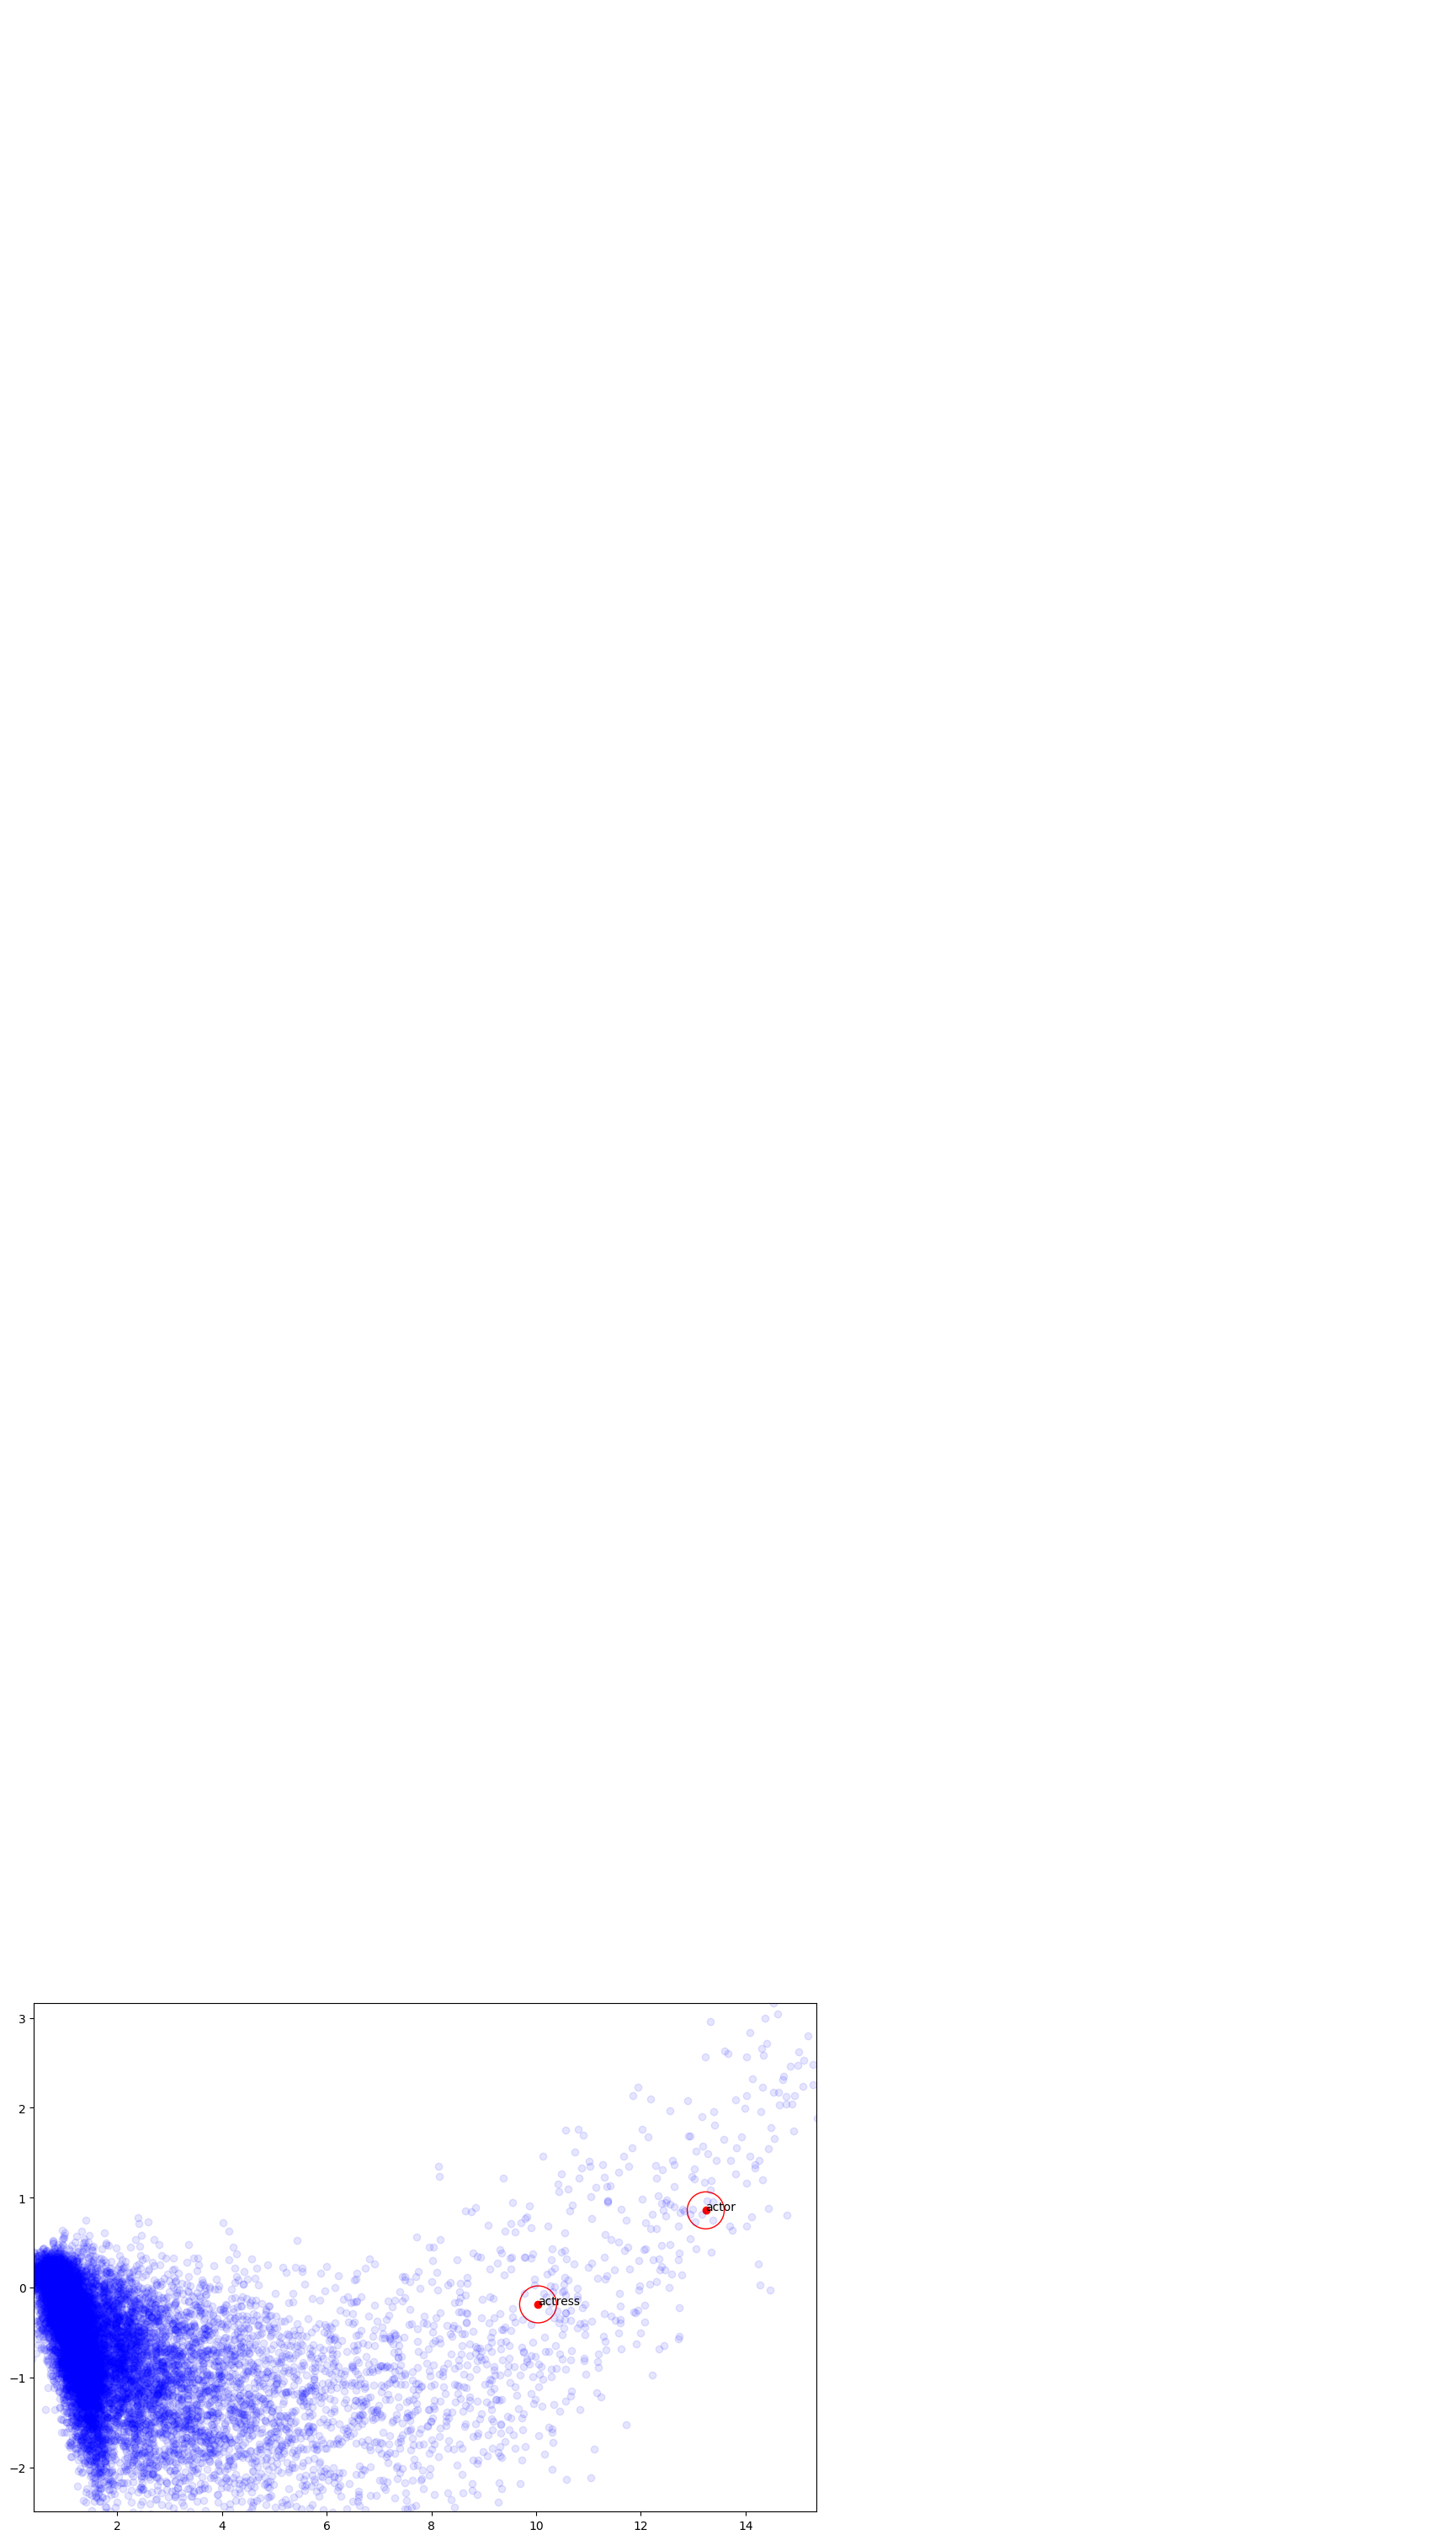

In [200]:
utils.visualize_embeddings(ppmi_svd, words_to_highlight, word_to_idx)

In [149]:
ppmi_tsne = utils.reduce_tsne(ppmi_occurrence_matrix, seed=RANDOM_SEED)

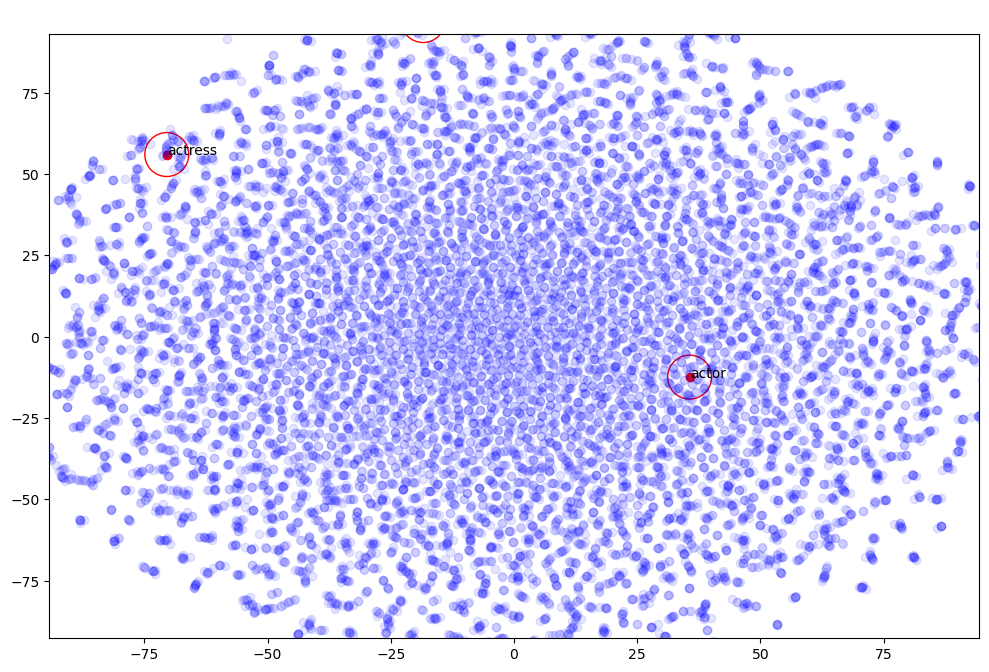

In [150]:
utils.visualize_embeddings(ppmi_tsne, words_to_highlight, word_to_idx)

And now we only focus on analogies$\dots$

In [178]:
test_analogies(ppmi_occurrence_matrix, word_to_idx, analogies, k=10)

Analogy male-female: man : woman = son : daughter

No exact analogies found

Actual similarity: 0.04323707171683003

Obtained results: ['son', 'surly', 'gables', 'moppet', 'betrothed', 'impoverished', 'traveled', 'heraunt', 'marquis', 'shearers']


Analogy jj-jjs: bad : worst = big : biggest

No exact analogies found

Actual similarity: 0.0062743744152140655

Obtained results: ['worst', 'quid', 'fat', 'hyped', 'naming', 'multiply', 'starcasted', 'budgeted', 'newt', 'spinal']


Analogy morph: free : freely = happy : happily

No exact analogies found

Actual similarity: -0.018032047245692236

Obtained results: ['freely', 'caustic', 'dispenses', 'advancement', 'ply', 'blessed', 'wit', 'paperbr', 'cursed', 'gorehounds']


Analogy feeling: poor : money = sad : happiness

No exact analogies found

Actual similarity: -0.00650213651496831

Obtained results: ['sad', 'tonys', 'laundering', 'sacks', 'greed', 'drank', 'weirdsville', 'inscription', 'supply', 'soapy']




Unfortunately, as with the raw co-occurrence count matrix, we are not able to retrieve any of the analogies we previously defined$\dots$

## Dense embeddings

Now we transition from sparse embeddings to dense embeddings. In particular, we will focus on two popular models, which are `Word2vec` and `GloVe` and we will use the `Gensim` library two download pre-trained embeddings and use them.

Moreover, we will handle OOV (Out Of Vocabulary) words in two different ways:
* `Random`: OOV words are represented by random vectors in a specific range (e.g. $[-1, 1]$)
* `Mean`: OOV words are represented by the average of the neighboring vectors in the dataset (where neighbors are computed from the co-occurrence count matrix), but if every neighbor is also OOV then we resort to random initialization

To be clear, by OOV word we mean a word which is present in our specific dataset but not in the pre-trained embedding model.

In [45]:
def check_oov_terms(embedding_model, word_listing):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms
    """
    oov_terms = []
    for word in word_listing:
        if word not in embedding_model.vocab:
            oov_terms.append(word)
    return oov_terms

In [46]:
def build_embedding_matrix(
    embedding_model,
    embedding_dimension,
    word_to_idx,
    idx_to_word,
    oov_terms,
    coo_matrix,
    method="mean",
):
    """
    Builds the embedding matrix of a specific dataset given a pre-trained Gensim word embedding model
    """

    def random_embedding(embedding_dimension, interval=(-1, 1)):
        return interval[0] + np.random.sample(embedding_dimension) + interval[1]

    embedding_matrix = np.zeros((len(word_to_idx), embedding_dimension))
    for word, index in word_to_idx.items():
        # Words that are no OOV are taken from the Gensim model
        if word not in oov_terms:
            word_vector = embedding_model[word]
        # OOV words computed as the mean of not OOV neighboring words in the dataset
        elif method == "mean":
            neighboring_word_indices = coo_matrix.indices[
                coo_matrix.indptr[index]:coo_matrix.indptr[index + 1]
            ]
            neighboring_word_vectors = np.array(
                [
                    embedding_model[idx_to_word[k]]
                    for k in neighboring_word_indices
                    if idx_to_word[k] in embedding_model
                ]
            )
            # Check if at least one neighboring word is in the Gensim model vocabulary
            if len(neighboring_word_vectors) > 0:
                word_vector = np.mean(neighboring_word_vectors, axis=0)
            # If not, resort to random vectors
            else:
                word_vector = random_embedding(embedding_dimension)
        # OOV words computed as random vectors in range [-1, 1]
        elif method == "random":
            word_vector = random_embedding(embedding_dimension)
        embedding_matrix[index, :] = word_vector
    return embedding_matrix

### Word2Vec

In [181]:
w2v_dimension = 300
w2v_model = utils.load_embedding_model("word2vec", w2v_dimension)

In [182]:
w2v_oov_terms = check_oov_terms(w2v_model, word_listing)
print(
    f"Total OOV terms: {len(w2v_oov_terms)} ({round(len(w2v_oov_terms) / len(word_listing), 2)}%)"
)

Total OOV terms: 2744 (0.2%)


In [183]:
w2v_matrix = build_embedding_matrix(
    w2v_model,
    w2v_dimension,
    word_to_idx,
    idx_to_word,
    w2v_oov_terms,
    co_occurrence_matrix,
)

In [184]:
print(f"Word2vec embedding matrix dimension: {w2v_matrix.shape}")

Word2vec embedding matrix dimension: (13413, 300)


As before, we proceed with visualization$\dots$

In [185]:
w2v_svd = utils.reduce_svd(w2v_matrix, seed=RANDOM_SEED)

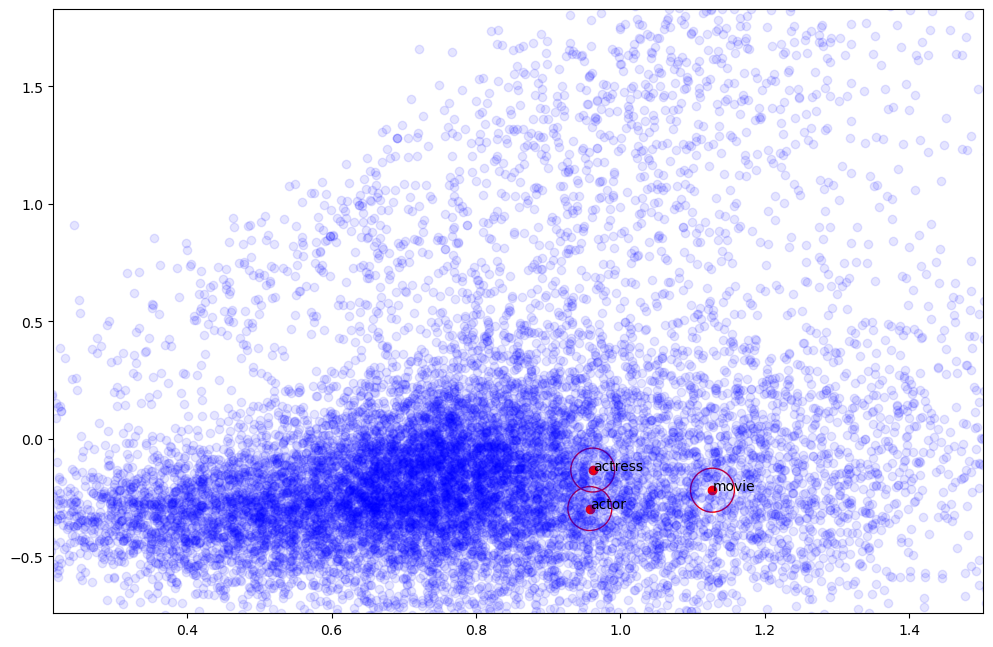

In [186]:
utils.visualize_embeddings(w2v_svd, words_to_highlight, word_to_idx)

In [187]:
w2v_tsne = utils.reduce_tsne(w2v_matrix, seed=RANDOM_SEED)

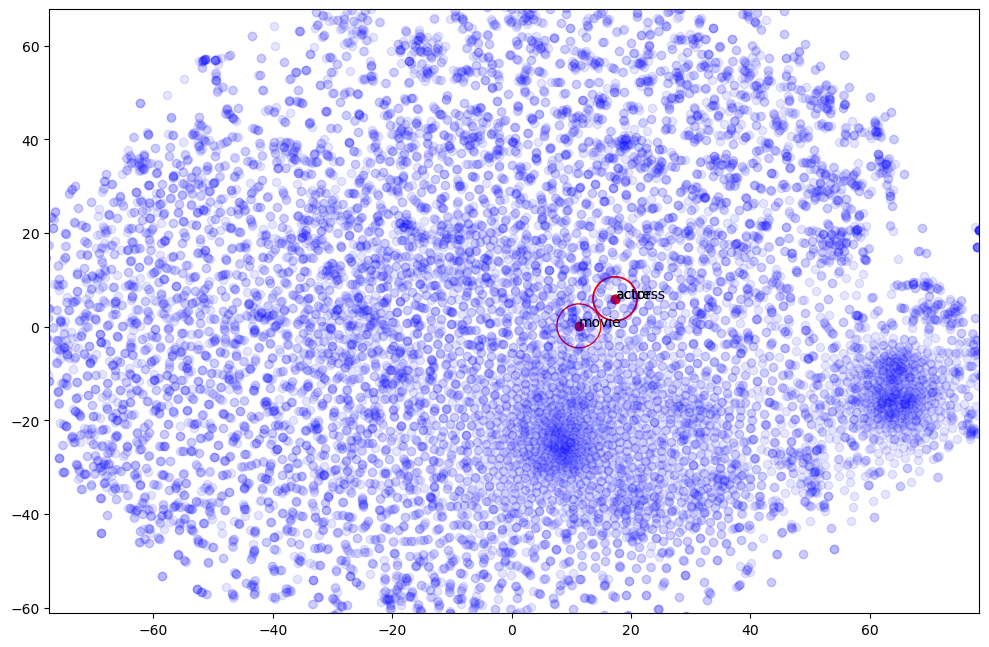

In [188]:
utils.visualize_embeddings(w2v_tsne, words_to_highlight, word_to_idx)

And we still focus only on analogies$\dots$

In [195]:
test_analogies(w2v_matrix, word_to_idx, analogies, k=10)

Analogy male-female: man : woman = son : daughter

No exact analogies found

Actual similarity: 0.8964177320974144

Obtained results: ['mother', 'son', 'husband', 'granddaughter', 'father', 'daughters', 'grandson', 'sister', 'wife', 'grandmother']


Analogy jj-jjs: bad : worst = big : biggest

No exact analogies found

Actual similarity: 0.7552486356977551

Obtained results: ['worst', 'greatest', 'big', 'major', 'strongest', 'deepest', 'scariest', 'fiercest', 'huge', 'hardest']


Analogy morph: free : freely = happy : happily

Exact analogy found with score 0.6233240324964188


Analogy feeling: poor : money = sad : happiness

No exact analogies found

Actual similarity: 0.17476421557299257

Obtained results: ['money', 'saddening', 'nishi', 'singingbr', 'bittersweet', 'sadness', 'pencilwork', 'glad', 'funds', 'lydons']




### GloVe

In [118]:
glove_dimension = 50
glove_model = utils.load_embedding_model("glove", glove_dimension)

In [119]:
glove_oov_terms = check_oov_terms(glove_model, word_listing)
print(
    f"Total OOV terms: {len(glove_oov_terms)} ({round(len(glove_oov_terms) / len(word_listing), 2)}%)"
)

Total OOV terms: 1791 (0.13%)


In [120]:
glove_matrix = build_embedding_matrix(
    glove_model,
    glove_dimension,
    word_to_idx,
    idx_to_word,
    glove_oov_terms,
    co_occurrence_matrix,
)

In [121]:
print(f"GloVe embedding matrix dimension: {glove_matrix.shape}")

GloVe embedding matrix dimension: (13413, 50)


As before, we proceed with visualization$\dots$

In [196]:
glove_svd = utils.reduce_svd(glove_matrix, seed=RANDOM_SEED)

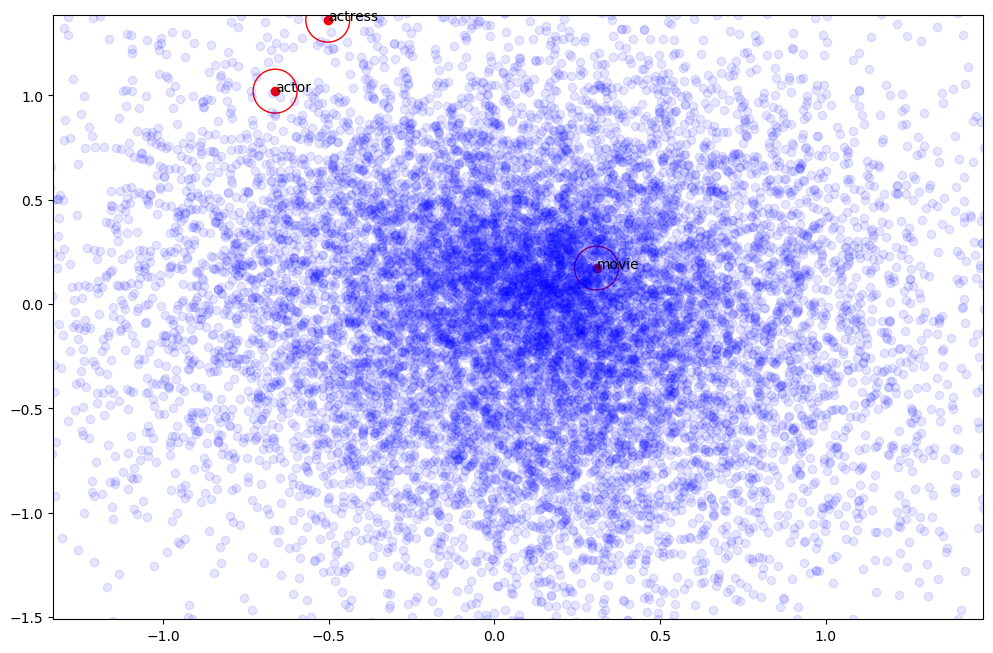

In [197]:
utils.visualize_embeddings(glove_matrix, words_to_highlight, word_to_idx)

In [198]:
glove_tsne = utils.reduce_tsne(glove_matrix, seed=RANDOM_SEED)

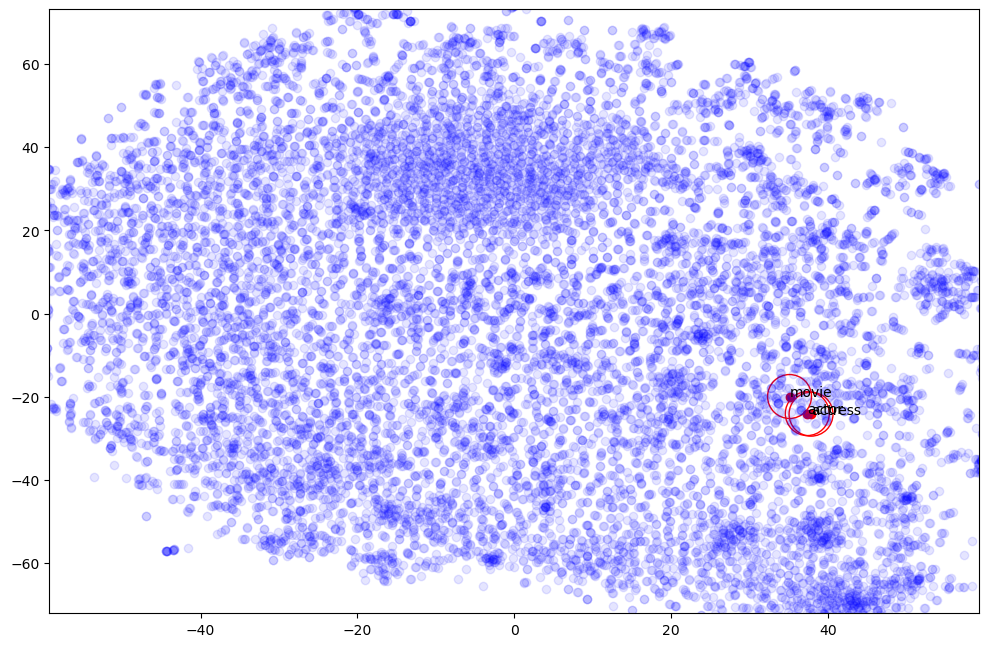

In [199]:
utils.visualize_embeddings(glove_tsne, words_to_highlight, word_to_idx)

And we still focus only on analogies$\dots$

In [179]:
test_analogies(glove_matrix, word_to_idx, analogies, k=10)

Analogy male-female: man : woman = son : daughter

No exact analogies found

Actual similarity: 0.9658341424188481

Obtained results: ['mother', 'wife', 'son', 'father', 'granddaughter', 'married', 'grandmother', 'cousin', 'widow', 'husband']


Analogy jj-jjs: bad : worst = big : biggest

No exact analogies found

Actual similarity: 0.8059626938067708

Obtained results: ['worst', 'big', 'nation', 'major', 'huge', '27part', 'coming', 'massive', 'leading', 'last']


Analogy morph: free : freely = happy : happily

No exact analogies found

Actual similarity: 0.8177949403866722

Obtained results: ['amazed', 'behave', 'honestly', 'thrilled', 'excited', 'annoyed', 'dwell', 'laughing', 'genuinely', 'glad']


Analogy feeling: poor : money = sad : happiness

No exact analogies found

Actual similarity: 0.3939093045994584

Obtained results: ['sobadsogood', 'dvdcasing', 'headscratcher', 'sameold', 'b+', '1991s', 'imagine', 'nothing', 'thing', 'frustrationbr']




## Conclusions

As we are able to see from the results we got, semantic structure is captured much better by dense embeddings w.r.t. sparse embeddings. 

In particular, even though we were not able to perfectly match analogies, we can observe that the returned words are most of the time meaningful to the analogy itself and that the actual similarity between the analogy vector (computed by linearly combining the analogy tokens) has a very high similarity score with the word vector that we were trying to predict (i.e. the last token of the analogy). Anyway, we can see that this patterns emerge only when using dense embeddings.

## Credits

Some code blocks, especially those regarding dataset loading/initialization and embeddings visualization, were taken from a notebook as part of an assignment for the NLP course of the Artificial Intelligence master's degree, at University of Bologna. The cited notebook is maintained by Andrea Galassi, Federico Ruggeri and Paolo Torroni.